# Image Classification ile Mama Kabındaki Yabancı Cisimlerin Tespiti

Bağlı bulunan kamera tarafından akıllı mama kabının üstünden veya yanından çekilmiş fotoğraflarda mama kabının içerisinde mama veya yabancı cisim olup olmadığının tespit edilmesini sağlayan derin öğrenme modelinin geliştirilmesi

Gerekli kütüphanelerin import edilmesiyle başlayalım

In [1]:
import pandas as pd
import numpy as np
import random
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import ResNet50V2

Using TensorFlow backend.


# 1. Veri Setini Tanıyalım

Elimizde Arduinoya bağlı bir kamera olmadığı için internet üzerinden boş veya mama dolu olan mama kaplarının fotoğraflarını aldık. Yabancı cisimler için hayvan besleyen arkadaşlarımızdan da yardım alarak kendi setimizi oluşturduk.

In [2]:
# Normal ve Anormal fotoğrafların bulunduğu klasörleri alalım
normal_path = os.getcwd() + "/images/normal/"
abnormal_path = os.getcwd() + "/images/abnormal/"

# Dosya isimlerini alalım
normal_images_names = os.listdir(normal_path)
abnormal_images_names = os.listdir(abnormal_path)

# Dictionary içerisinde görselleri ve etiketleri tutalım
# 0 - Normal Durum
# 1 - Anormal Durum

dictionary = {"Image": [], "Label":[]}

for image_name in normal_images_names:
    img=image.load_img(normal_path + image_name, target_size=(224,224), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    dictionary["Image"].append(img)
    dictionary["Label"].append(0)
        
        
for image_name in abnormal_images_names:
    img=image.load_img(abnormal_path + image_name, target_size=(224,224), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    dictionary["Image"].append(img)
    dictionary["Label"].append(1)

# Pandas DataFrame oluşturalım
data = pd.DataFrame.from_dict(dictionary)


C:\Users\bhasfe\anaconda3\envs\tensorflow\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Veri setimizi oluşturduk. Kısaca gözatalım

In [3]:
# Verisetindeki ilk 10 kolonu gösterelim
display(data.head(10))

# Info
print(data.info())

# Özet istatistiklere bakalım
display(data.describe())

,Image,Label
0,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
1,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
2,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
3,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
4,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
5,"[[[1.0, 0.9882353, 0.96862745], [1.0, 0.988235...",0
6,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
7,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
8,"[[[0.7411765, 0.4745098, 0.21960784], [0.72549...",0
9,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   162 non-null    object
 1   Label   162 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.7+ KB
None


,Label
count,162.000000
mean,0.290123
std,0.455226
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Elimizde hangi etiketten kaçta olduğuna bakalım

Label
0    115
1     47
dtype: int64


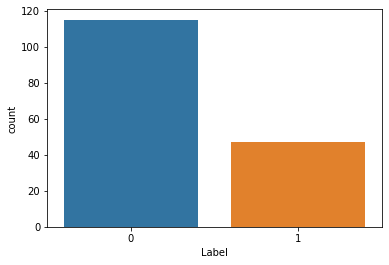

In [4]:
# Etiket sayılarını bastıralım
print(data.value_counts("Label"))

# Etiket sayılarını görselleştirelim
sns.countplot(data=data, x="Label")

Bazı görsellere göz atalım

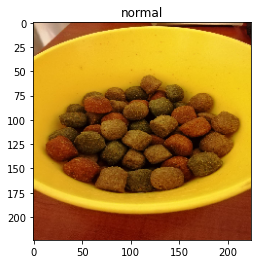

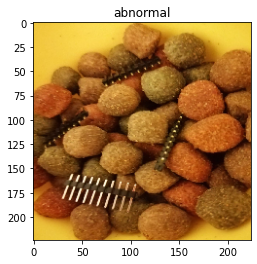

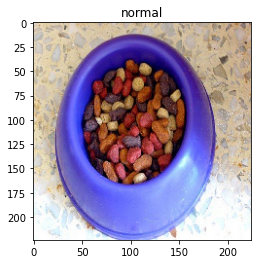

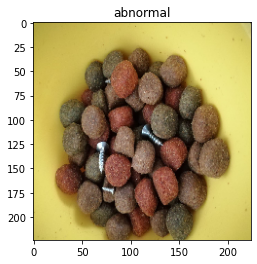

In [5]:
random.seed(35)
def show_pictures(label):
    
    if label == "normal":
        path = os.getcwd() + "/images/normal/"
    elif label == "abnormal":
        path = os.getcwd() + "/images/abnormal/"
    else:
        print("Invalid Label")
        
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)
    img_tensor /= 255.
    plt.title(label)
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures("normal")
    show_pictures("abnormal")

# 2. Modeli Oluşturalım ve Eğitelim

Öncelikle elimizdeki veri setini Train ve Test(Validation) setleri olarak ayıralım. Elimizdeki veri sınırlı sayıda olduğu için üç ayrı sete bölmeyeceğiz.

In [6]:
# Bağımlı ve bağımsız değişkenlerimizi seçelim
X = np.array(dictionary["Image"])
y = np.array(dictionary["Label"])

# Eğitim ve Test(Validation) verisi olarak verimizi bölelim
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=34,test_size=0.3,stratify=y)

# Boyutlar ile ilgili gerekli ayarlamaları yapalım
X_train = X_train.reshape(X_train.shape[0], 224, 224, 3)
X_test = X_test.reshape(X_test.shape[0], 224, 224, 3)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

ImageDataGenerator yardımıyla elimizdeki görsellerden yeni görseller türetelim

In [7]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.2,1.2])

Modelimizi Oluşturmaya başlayalım. Elimizdeki veriseti oldukça sınırlı olduğu için **Resnet50V2** ile Transfer Learning kullanacağız.

In [8]:
# Resnet50V2 base modelimizi oluşturalım
base_model = ResNet50V2(
    include_top=False, weights='resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5', input_tensor=None, input_shape=None,
    pooling=None, classes=1000)
 
# Resnet modelindeki son katmanı alalım
new = base_model.output
 
# Global Average Pooling ekleyelim
new = GlobalAveragePooling2D()(new)
 
# 1024 Nörondan oluşan relu aktivasyon fonksiyonunu kullanan bir katman ekleyelim
new = Dense(1024, activation='relu')(new)
 
# Sınıflandırmayı yapacak olan tek nöron içeren katmanımızı ekleyelim
classifier = Dense(1, activation='sigmoid')(new)
 
# Modelimizi oluşturalım
model = Model(inputs=base_model.input, outputs=classifier)
 
# Resnet modelimizi eğitmeyeceğimiz için layerların trainable özelleğini False yapıyoruz
for layer in base_model.layers:
    layer.trainable = False

    
# Modelimizi compile edelim
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

# Model özetini bastıralım
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Daha önceden hazırlamış olduğumuz ImageDataGenerator'ı kullanalım

Artık modelimizi eğitebiliriz

In [29]:
# Directly use .flow()
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=1), 
                    epochs=10,
                    steps_per_epoch=200,
                    validation_data=(X_test, y_test),
                    validation_steps=200,
)

Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 0.2172 - accuracy: 0.9250 - val_loss: 1.6080 - val_accuracy: 0.8163
Epoch 2/10
200/200 [==============================] - 4s 18ms/step - loss: 0.1994 - accuracy: 0.9000 - val_loss: 1.3261 - val_accuracy: 0.7959
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1684 - accuracy: 0.9250 - val_loss: 2.4056 - val_accuracy: 0.7755
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 0.2197 - accuracy: 0.8900 - val_loss: 1.6560 - val_accuracy: 0.8163
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.2506 - accuracy: 0.9000 - val_loss: 1.4007 - val_accuracy: 0.8163
Epoch 6/10
200/200 [==============================] - 4s 18ms/step - loss: 0.1901 - accuracy: 0.9000 - val_loss: 1.7268 - val_accuracy: 0.8163
Epoch 7/10
200/200 [==============================] - 4s 18ms/step - loss: 0.1771 - accuracy: 0.9200 - val_loss: 1.5499 - val_accuracy: 0.8163

Başarımızı test edelim

In [30]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:"+": %.2f%%" % (scores[1]*100))

49/49 [==============================] - 0s 4ms/step
Test Accuracy:: 83.67%


Eğitimdeki Accuracy ve Loss grafiklerine bakalım

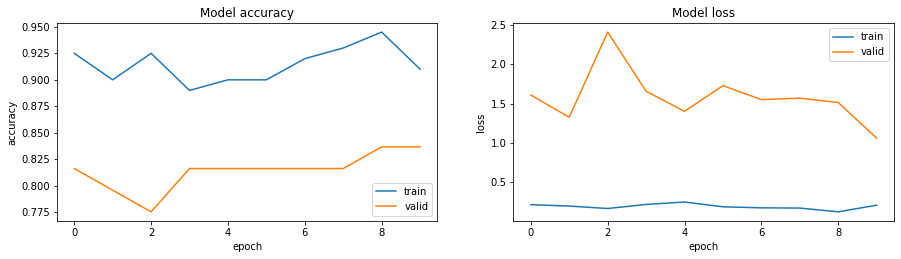

In [31]:
# Plot oluşturalım
plt.figure(1, figsize = (15,8)) 

# Accuracy durumu
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

# Loss durumu
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

Modeli sunucuda kullanmak üzere kaydedelim

In [32]:
# Modeli kaydedelim
with open("isfood_model.json", "w") as json_file: 
    json_file.write(model.to_json())
    
# Model ağırlıklarını kaydedelim
model.save_weights("is_foodweights.h5")